#BGSL Recognition
The objective of this project is to implement a fast and accurate model for translation of Bulgarian Sign Language into to a text format

This is the first project that attempts to implement such a model. It is significant for society since it will allow deaf and deaf-mute people to be understood by the broader community who do not know sign language. It will also help integrate deaf people better into society, fostering relationships and friendships.

This project is the first of its kind to implement such a learning model. Its societal significance lies in its ability to help deaf and deaf-mute individuals communicate with the broader community, even with those unfamiliar with sign language. By doing so, it will help better social integration, fostering meaningful relationships and friendships.


Currently it is implemented only for translation of letters from BGSL to text due to dataset constraints

The current aproach is as follows


*   Take frames from video
*   From each frame extract hand landmarks using Mediapipe API
*   Filter out frames with no landmarks
*   Pad number of frames to a constant size of 80 so they can be fed into the LSTM Neural Network
* Split each video into segments of frames - for example segments of 30 frames with 10 stride between frames

LSTMs are an improvement over regular RNNs - Recurrent Neural Networks. They are good at capturing long range dependencies due to their internal memory state. Another great property of theirs are their forget, update and output gates. The forget gate decides what information to forget from the previous cell state, the update gate decides what information to add and the output gate decides what information the new hidden state should carry.

The forget gate uses a sigmoid $\sigma$ activation function which outputs real numbers ranging from 0 to 1. When the input $ x <= 0$ is, the output is zero, if is $ x> 0$ it outputs a number real number.
The update and output gate use a Tanh activation which outputs number from -1 to 1.


[LSTM paper ](https://www.bioinf.jku.at/publications/older/2604.pdf)

LSTM Diagram






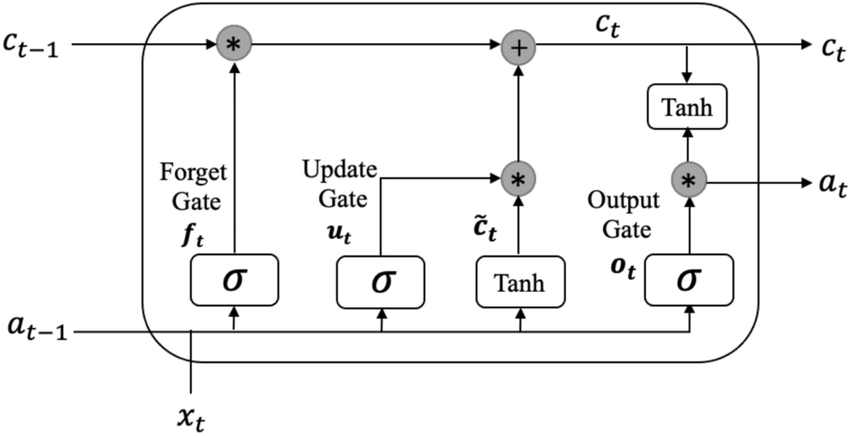

BGSL Recogntion diagram
The diagram desribes the process of processing and predicting a letter from an image frame

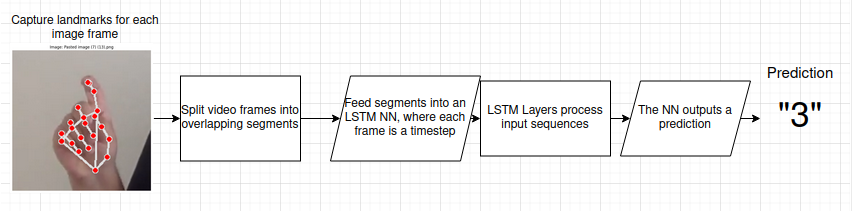

#Setup
Below are the necessary imports for the project

In [ ]:
#Imports
!pip install mediapipe #run this only if using the video proceessing cell
import mediapipe as mp
!pip install -q -U keras-tuner
import keras_tuner as kt
import cv2
import numpy as np
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from google.colab.patches import cv2_imshow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense
from sklearn.model_selection import KFold




#Data manipulation

Here we are splitting a video into frames and capturing a landmark for each frame of the video. The video frames are then padded to a constant size of 80.

 Currently if only one hand is detected we pad the frames with another hand containg empty landmark vectors. That is done for a couple of reasons.


1.   The first idea is that by doing that we are keeping information about the second hand being present from frames that do contain two hands. In real use cases most of the time 2 hands will be visible and the model should be able to account for which hand is actually important. The best way to do that is by having examples where there are two hands but only one of them is actually active. This way the model will not be starstruck when it encounters two hands since it has already seen such examples.

2. The second idea is that this model could later be expanded into a full translator from sign language to words and when deaf invidivuals communicate they use both of their hands. That is coupled with the fact that there is a two hand sign language alphabet that is used by many deaf people in Bulgaria.

Frames with no landmarks detected are filtered out because they represent no meaningful information.

In [ ]:
base_dir = '/content/drive/MyDrive/bsl_data/'

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.3,
    min_tracking_confidence=0.3
)

def normalize_landmarks(hand_landmark_vector):
    arr = np.array(hand_landmark_vector, dtype=np.float32)
    min_val = arr.min()
    max_val = arr.max()
    normalized = (arr - min_val) / (max_val - min_val + 1e-8) # normalize between 0 and 1
    return normalized.tolist()

def video_processing():
    """
    Process videos in the base directory by extracting and saving hand landmark sequences.
    If only one hand is detected in a frame, the sequence is padded with an empty landmark vector.
    """
    for subdir in os.listdir(base_dir):
        subdir_path = os.path.join(base_dir, subdir)
        if os.path.isdir(subdir_path):
            for file in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, file)
                if file_path.endswith(".mp4"):
                    print("Processing video:", file_path)
                    cap = cv2.VideoCapture(file_path)
                    landmark_sequences = []

                    while cap.isOpened():
                        ret, frame = cap.read()
                        if not ret:
                            break


                        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        image_rgb.flags.writeable = False
                        results = hands.process(image_rgb)
                        frame_landmarks = []

                        if results.multi_hand_landmarks:
                            for hand_landmarks in results.multi_hand_landmarks:
                                hand_landmark_vector = []
                                for lm in hand_landmarks.landmark:
                                    hand_landmark_vector.extend([lm.x, lm.y, lm.z])
                                hand_landmark_vector = normalize_landmarks(hand_landmark_vector)
                                frame_landmarks.append(hand_landmark_vector)
                                mp_drawing.draw_landmarks(
                                    frame, hand_landmarks, mp_hands.HAND_CONNECTIONS
                                )
                        else:
                            print("No hands detected in this frame.")
                            # Uncomment the following line to display the frame for debugging
                            # cv2_imshow(frame)
                            if cv2.waitKey(0) & 0xFF == 27:
                                break

                        landmark_sequences.append(frame_landmarks)

                        # Uncomment the following line to display the frame for debugging
                        # cv2_imshow(frame)
                        if cv2.waitKey(1) & 0xFF == 27:
                            break

                    # Filter out frames with no landmarks
                    non_empty_sequences = [seq for seq in landmark_sequences if seq]
                    if non_empty_sequences:
                        padded_sequences = pad_sequences(
                            non_empty_sequences,
                            maxlen=2,
                            dtype="float32",
                            padding="post",
                            truncating="post",
                        )
                        flattened_video = padded_sequences.reshape(padded_sequences.shape[0], -1)
                        padded_sequences = pad_sequences(
                            [flattened_video],
                            maxlen=80,
                            dtype="float32",
                            padding="post",
                            truncating="post",
                        )[0]

                        save_filename = f"landmarks_video{video_count}_{subdir}.npy"
                        save_path = os.path.join(subdir_path, save_filename)
                        np.save(save_path, padded_sequences)
                        print(f"Saved landmarks to: {save_path}")
                    else:
                        print("No valid landmark sequences extracted for this video.")

                    cap.release()
                    cv2.destroyAllWindows()

    hands.close()

video_processing()

print("Total frames processed:", frames)


#Data processing
Run this each time to prepare dataset from numpy files.
Here the data was saved to the numpy files in the previous step is processed into segments of overlapping frames and later made into training and test set.
This is without linear interpolation of frame landmarks
It reads data from the class directories, saves the segments and their labels and turns them itno datasets.
We split the dataset here into 90% training and 10% testing with stratification ensuring that we have equal distribution of classes.
We use 90% for training and only have 10% and validation because our data is limited and I was trying to make the most of it.

File structure is:
 /path/to/data/A/sample1.npysample2.npy ...
Where we have a base directory with class folders       

In [ ]:
base_dir = '/content/drive/MyDrive/bsl_data'

def interpolate_frame_landmarks(frame_segments, additional_frame_count=20): # linear interpolation
  concatenated_segments = []
  for segment in frame_segments:
    T, features = np.array(segment).shape
    original_indices = np.linspace(0,1,T) # generate array of T evenly spaced nums between 0,1 original frames
    new_indices = np.linspace(0,1,additional_frame_count) # target positions for new frames
    new_frames = np.zeros((additional_frame_count,features), dtype=segment.dtype)
    for i in range (features):w
      new_frames[:, i] = np.interp(new_indices, original_indices, segment[:, i])
    concatenated_segment = np.concatenate([segment, new_frames], axis=0)
    concatenated_segments.append(concatenated_segment)

  return np.array(concatenated_segments)



def segment_video(video_array, segment_length=40, stride=20):

    segments = []
    for start in range(0, video_array.shape[0] - segment_length + 1, stride):
        segments.append(video_array[start:start + segment_length])
    return segments



def construct_dataset(base_dir, one_hot_encoding=False, interpolate=False):

  data_list = []
  labels_list = []
  batch_size = 64

  classes = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])
  print("Classes found:", classes)

  class_to_int = {cls: idx for idx, cls in enumerate(classes)}
  total_splits = 0

  for cls in classes:
      folder_path = os.path.join(base_dir, cls)
      for file in os.listdir(folder_path):
          if file.endswith('.npy'):
              file_path = os.path.join(folder_path, file)
              video_data = np.load(file_path)
              segments = segment_video(video_data, segment_length=30, stride=10)
              total_splits+= len(segments)
              for seg in segments:
                data_list.append(seg)
                labels_list.append(class_to_int[cls])

  data_array = np.array(data_list, dtype='float32')

  labels_array = np.array(labels_list, dtype='int32')

  if interpolate:
    interpolated_data = interpolate_frame_landmarks(data_array, additional_frame_count=20)
    data_array = np.array(interpolated_data, dtype='float32')

  if(one_hot_encoding):
    labels_one_hot = to_categorical(labels_array, num_classes=30)
    labels_array = labels_one_hot


  print("Data shape:", data_array.shape)
  print("Labels shape:", labels_array.shape)


  X_train, X_test, y_train, y_test = train_test_split(
      data_array, labels_array, test_size=0.1, random_state=42, stratify=labels_array
  )

  X_test, X_val, y_test, y_val = train_test_split(
      data_array, labels_array, test_size=0.5, random_state=42, stratify=labels_array
  )

  train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
  test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
  val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))


  train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE).shuffle(1000)
  test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE).shuffle(1000)
  val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE).shuffle(1000)

  for batch_data, batch_labels in train_dataset.take(1):
    print("Batch data shape:", batch_data.shape)
    print("Batch labels shape:", batch_labels.shape)
  return train_dataset, test_dataset, val_dataset

train_dataset, test_dataset, val_dataset = construct_dataset(base_dir)





#Model 1 LSTM-64-1L

This model is the simplest I have tried. It has a masking layer that removed frames added for padding, one LSTM layer, Dropout added to the output of the LSTM layer and a Dense layer for predicting probabilities for each class.
When trying this model the videos were split into 20 frame segments with a 10 frame overlap. The final Dense layer is used to classify between the 30 classes. In order to convert the raw logits into a probability distribution we use a softmax activation.
Softmax takes the form $\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}}
$
In this formula $z_i$ is the input score for one class $n$ is the number of classes

In [ ]:
def create_model(learning_rate=0.001, loss=tf.keras.losses.sparse_categorical_crossentropy):
  model = tf.keras.Sequential([
      tf.keras.layers.Masking(mask_value=0.0, input_shape=(80,126)), # Masking layer to get rid of padded frames
      tf.keras.layers.LSTM(64),
      tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Dense(30, activation = 'softmax')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=loss, metrics=['accuracy'])
  return model

model1 = create_model()
model1.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_11 (Masking)                 │ (None, 80, 126)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 64)                  │          48,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 30)                  │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,846 (198.62 KB)

 Trainable params: 50,846 (198.62 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model1.fit(train_dataset, epochs=500)

In [ ]:
model1.evaluate(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6333 - loss: 0.9680 


[0.8622097373008728, 0.699999988079071]

After seeing that the model performs relatively poorly at generalization(loss test set accuracy) I tried the same model with the KL divergence loss function to see if there will be any difference
Kullback–Leibler divergence also known as KL divergence is a loss function that measures how different one probability distribution $Q$ is from a reference distribution $P$

It takes the form $D_{KL}(P || Q) = \sum_{x} P(x) \log\left(\frac{P(x)}{Q(x)}\right)$

Where $P(x)$ is the true distribution of the data, and $Q(x)$ is the predicted distribution.

 $D_{KL}(P || Q)$ represents the divergence of $Q$ from $P$

 So we have the sum of the difference between the true distribution and the predicted distriution for every event $x$

In [ ]:
tensorboard_dir = '/content/tensorboard/LSTM-64-1L-KL'
tensorboard_callback = TensorBoard(log_dir=tensorboard_dir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    min_lr=0.00001,
)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/checkpoints/LSTM-64-1L-KL.weights.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [ ]:
train_dataset, test_dataset, val_dataset = construct_dataset(base_dir, one_hot_encoding=True)
model_kl = create_model(learning_rate=0.0001, loss=tf.keras.losses.KLDivergence())
model_kl.fit(train_dataset, epochs=500, validation_data=val_dataset, callbacks=[reduce_lr,tensorboard_callback,checkpoint_callback])

In [ ]:
model_kl.evaluate(test_dataset) # eval on test set after 500 epochs


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8446 - loss: 0.6494


[0.6966719031333923, 0.8351648449897766]

Here we are training the model for additional epochs to see if they will benefit it. I observe very little change but I will try training it even more

500 additional epochs

In [ ]:
# model_kl = create_model(learning_rate=0.001, loss=tf.keras.losses.KLDivergence())
# model_kl.load_weights('/content/checkpoints/LSTM-64-1L-KL.weights.h5')
model_kl.fit(train_dataset, epochs=500, validation_data=val_dataset, callbacks=[reduce_lr,tensorboard_callback,checkpoint_callback])# additional training to see if the model will perform better

In [ ]:
%load_ext tensorboard

%tensorboard --logdir /content/tensorboard/LSTM-64-1L-KL

By using tensorboard we can see some details about the training of this model

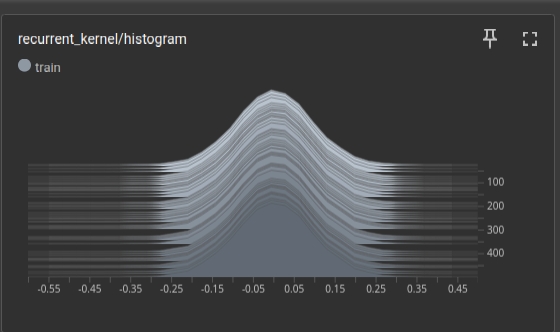

The recurrent kernel diagram shows us that the recurrent connection weights are centered around zero maintaing a similar shape throughout training. This tells us that training was steady and there were no exploding or vanishing gradients.

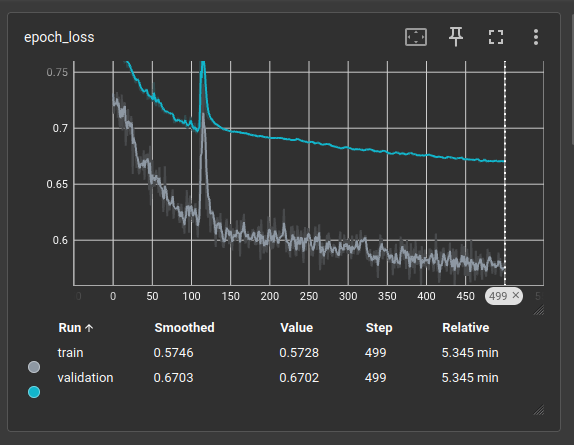

The epoch loss diagram shows us that loss for both training validation drops overall with more training .There is a spike at about the 100th epoch. At about the 400th epoch the loss starts to become consistent.

#Model 2 - LSTM-128-64-2L
Here I wanted to try a slightly more complex model with two LSTM Layers.
I have also doubled the size of the first LSTM layer to 128 units, while the second one is 64.
I am also using recurrent dropout of 0.2 for the first layer. That randomly sets 20% of the input features from the previous hidden state to 0. This method is effective to prevent overfitting and to make sure the neural network is not too reliant on a specific hidden state.


mistake here
To the second layer I have applied regular activation that is applied to the the input features of each time step

We also have a Dense layer with softmax activation like before


In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value=0.0, input_shape=(80,126)),
    tf.keras.layers.LSTM(128, return_sequences=True, recurrent_dropout=0.2 ),
    tf.keras.layers.LSTM(64, dropout=0.2),
    tf.keras.layers.Dense(30,activation='softmax')
])

In [ ]:
model2.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

In [ ]:
model2.compile(loss=tf.keras.losses.KLDivergence(), optimizer='adam', metrics=['accuracy'])

In [ ]:
tensorboard_dir = '/content/tensorboard/LSTM-128-64-2L'
tensorboard_callback = TensorBoard(log_dir=tensorboard_dir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    min_lr=0.00001,
)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/checkpoints/LSTM-128-64-2L.weights.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)
model2.fit(train_dataset, epochs = 500, validation_data=val_dataset, callbacks=[tensorboard_callback, reduce_lr, checkpoint_callback] ) # these were only additional epochs

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.8289 - loss: 0.7541 - val_accuracy: 0.8278 - val_loss: 0.7297 - learning_rate: 1.0000e-05
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.8403 - loss: 0.7027 - val_accuracy: 0.8278 - val_loss: 0.7290 - learning_rate: 1.0000e-05
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step - accuracy: 0.7920 - loss: 0.7830 - val_accuracy: 0.8278 - val_loss: 0.7287 - learning_rate: 1.0000e-05
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 290ms/step - accuracy: 0.8149 - loss: 0.7802 - val_accuracy: 0.8278 - val_loss: 0.7290 - learning_rate: 1.0000e-05
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.8324 - loss: 0.7013 - val_accuracy: 0.8315 - val_loss: 0.7293 - learning_rate: 1.0000e-05
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - accuracy: 0.8000 - loss: 0.7982 - val_accuracy: 0.8315 - val_loss: 0.7292 - learning_rate: 1.0000e-05
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.8414 

In [ ]:
%load_ext tensorboard

%tensorboard --logdir /content/tensorboard/LSTM-128-64-2L

In [ ]:
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)                  │ (None, 80, 126)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 80, 128)             │         130,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30)                  │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 181,918 (710.62 KB)

 Trainable params: 181,918 (710.62 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.fit(train_dataset, epochs = 50) # these were only additional epochs

In [ ]:
model2.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7609 - loss: 0.6219


[0.6218519806861877, 0.760869562625885]

In [ ]:
#save model
!mkdir -p saved_model
model.save('saved_model/my_model')

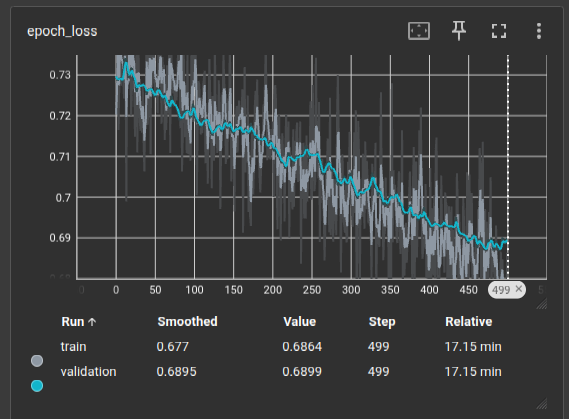

#Model 3 - LSTM-128-64-4L
In this model architecture we are adding another two smaller lstm layers and using the RMSprop optimizer

Also unlike the previous models we are using a smaller segment length of 20 with a stride between segments of 10. This means that each video's landmarks are split into parts of 20 frames and each one has 10 frames overlapping with the previous one. The idea behind that was to achieve a higher sample size.

After training for quite some epochs I adjusting learning rate manually

Root Mean Square Propagation also known as RMSprop is an adaptive gradient descent algorithm designed to improve training stability and convergence speed.

We are also using ReduceLRonPlateau


In [ ]:

log_dir  = '/content/logs/fit/'
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

model3 = model = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value=0.0, input_shape=(80,126)),
    tf.keras.layers.LSTM(128, return_sequences=True, recurrent_dropout=0.3),
    tf.keras.layers.LSTM(64, return_sequences=True, recurrent_dropout=0.2),
    tf.keras.layers.LSTM(32, return_sequences=True, recurrent_dropout=0.2),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(30, activation = 'softmax'),
])
#We are using RMSprop to help the model continue learning in the later stages
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='train_loss', factor=0.1, patience=7, min_lr=0.0001, mode ='min')
optimizer = tf.keras.optimizers.RMSprop()
model3.compile(
  optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
model3.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)                  │ (None, 80, 126)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 80, 128)             │         130,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 80, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 80, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │             510 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 196,030 (765.74 KB)

 Trainable params: 196,030 (765.74 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model3.fit(train_dataset, epochs = 600, callbacks=[reduce_lr, tensorboard_callback])

In [ ]:
model3.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)                  │ (None, 80, 126)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 80, 128)             │         130,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 80, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 80, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │             510 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 392,062 (1.50 MB)

 Trainable params: 196,030 (765.74 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 196,032 (765.75 KB)

In [ ]:
#Here I changed the dropout rate during training because I suspected that it was meddling with the training
new_lstm_layer = tf.keras.layers.LSTM(128, return_sequences=True, recurrent_dropout=0.1)
new_lstm_layer.build(sequences_shape=(None, 80, 126))
new_lstm_layer.set_weights(model3.layers[1].get_weights())
model.layers[1] = new_lstm_layer


In [ ]:
accuracy, loss = model3.evaluate(test_dataset) # 68 percent accuracy, worse than the smaller lstm with 40 segment size

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6875 - loss: 1.4355


These results show us that 20 frames with landmarks are probably not enough for the neural network to determine which hand sign it is.

In [ ]:

cur_lr = optimizer.learning_rate.numpy()
new_lr = cur_lr * 0.6
model3.optimizer.learning_rate.assign(new_lr)

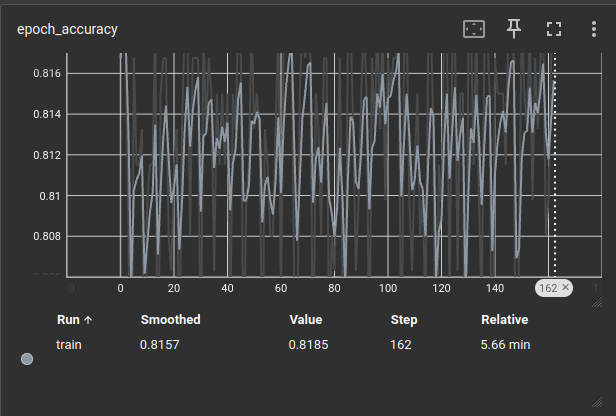

This graph shows us that for these 162 steps the accuracy was relatively stable and in the range of 80% to 81%

#Model 4 - LSTM-128-AT
In model 4 I decided to employ Bidirectional LSTMS which capture information from both front and back of a temporal sequence simultaneously.
It essentially consits of two LSTM layers, one processes the sequence from front to back and the other the opposite way, from the back to the front.
After processing, each time step has two hidden states one from the forward and one from the backward LSTM which are concatenated.

Along with the Bidirectional LSTMs I decide to employ attention after the last Bidirectional LSTM Layer. In the Attention layer the query is different from the key and value. The query is the output of the LSTM3 layer unaltered and the key and value are the same output with a dropout of 0.2 percent applied.
In a Multihead Attention layer we have three important parameters - query, key and value. We have attention heads which compare how similar the query and key are which results in weights used to scale the values.

In [ ]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization

log_dir  = '/content/logs/fit/'
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
input_shape = (30, 126)
inputs = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Masking(mask_value=0.0)(inputs)
lstm1 = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True, recurrent_dropout=0.2)
    ) (x)
lstm2 = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True, recurrent_dropout=0.2)
    )(lstm1)
lstm3 = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, return_sequences=True, recurrent_dropout=0.2)
    )(lstm2)
dropout = tf.keras.layers.Dropout(0.2)(lstm3)

attention = MultiHeadAttention(num_heads=4, key_dim=64)(query=lstm3, key=dropout, value=dropout)
layer_norm = LayerNormalization(epsilon=1e-6)(attention + lstm3) # residual connection
pooling = tf.keras.layers.GlobalAveragePooling1D()(layer_norm) # so i can feed it
outputs = tf.keras.layers.Dense(30, activation='softmax')(pooling)


optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001) # with added method to decay weights
model4 = tf.keras.models.Model(inputs=inputs, outputs=outputs)
# for model 4 we will use standard adam and towards the end when we achieve convergence we will optimize hyperparameters
model4.compile(
  optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)
model4.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 30, 126)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_8 (NotEqual)    │ (None, 30, 126)        │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking_7 (Masking)       │ (None, 30, 126)        │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any_9 (Any)               │ (None, 30)             │              0 │ not_equal_8[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 30, 256)        │        261,120 │ masking_7[0][0],       │
│ (Bidirectional)           │                        │                │ any_9[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 30, 128)        │        164,352 │ bidirectional_3[0][0], │
│ (Bidirectional)           │                        │                │ any_9[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 30, 64)         │         41,216 │ bidirectional_4[0][0], │
│ (Bidirectional)           │                        │                │ any_9[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 30, 64)         │              0 │ bidirectional_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 30, 64)         │         66,368 │ bidirectional_5[0][0], │
│ (MultiHeadAttention)      │                        │                │ any_9[0][0],           │
│                           │                        │                │ dropout_8[0][0],       │
│                           │                        │                │ any_9[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 30, 64)         │              0 │ multi_head_attention_… │
│                           │                        │                │ bidirectional_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 30, 64)         │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 64)             │              0 │ layer_normalization_1… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 30)             │          1,950 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 535,134 (2.04 MB)

 Trainable params: 535,134 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model4.fit(train_dataset, epochs = 600)

In [ ]:
model4.optimizer.learning_rate.assign(0.0001)

In [ ]:
model4.evaluate(test_dataset) #Falls short of expectations for a larger model

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7818 - loss: 0.9780


[0.9780060648918152, 0.7818182110786438]

#Model 5
Model 5 is trained with Keras tuner Hyperband which is used to find optimal hyperparameters for the model.
In order to provide the model with more data I decided to use  linear interpolation generate additional frames with landmarks.
Initially I was training with 60 additional frames to test how well it would with this much artifical data, but training was slow and I opted for just 20 more frames.
Below is a diagram of interpolation
Essentially what is happening is that we are inferring new data points from the ones we have.

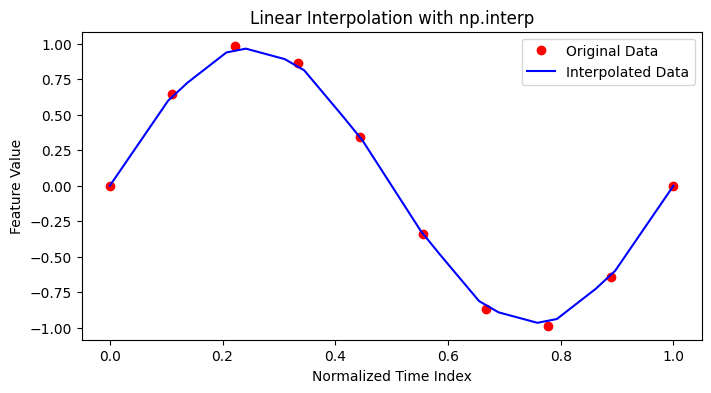

In [ ]:
train_dataset, test_dataset, eval_dataset = construct_dataset(base_dir=base_dir, one_hot_encoding=False, interpolate=False)

In [ ]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization

log_dir  = '/content/logs/fit/'
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
def model_builder(hp):

  input_shape = (50, 126)
  inputs = tf.keras.layers.Input(shape=input_shape)
  x = tf.keras.layers.Masking(mask_value=0.0)(inputs)

  lstm_units1 = hp.Int('lstm_units1', min_value=32, max_value=256, step=32)
  dropout_rate1 = hp.Float('dropout_rate1', min_value=0.1, max_value=0.5, step=0.1)
  lstm1 = tf.keras.layers.Bidirectional(
          tf.keras.layers.LSTM(lstm_units1, return_sequences=True, recurrent_dropout=dropout_rate1)
      ) (x)
  attention1 = MultiHeadAttention(num_heads=4, key_dim=128)(query=lstm1, value=lstm1)
  layer_norm1 = LayerNormalization(epsilon=1e-6)(attention1 + lstm1)

  lstm_units2 = hp.Int('lstm_units2', min_value=32, max_value=128, step=32)
  dropout_rate2 = hp.Float('dropout_rate2', min_value=0.1, max_value=0.5, step=0.1)

  lstm2 = tf.keras.layers.Bidirectional(
          tf.keras.layers.LSTM(lstm_units2, return_sequences=True, recurrent_dropout=dropout_rate2)
      )(layer_norm1)

  lstm_units3 = hp.Int('lstm_units3', min_value=32, max_value=64, step=32)
  dropout_rate3 = hp.Float('dropout_rate3', min_value=0.1, max_value=0.5, step=0.1)

  lstm3 = tf.keras.layers.Bidirectional(
          tf.keras.layers.LSTM(lstm_units3, return_sequences=True, recurrent_dropout=dropout_rate3)
      )(lstm2)
  attention2 = MultiHeadAttention(num_heads=4, key_dim=64)(query=lstm3, value=lstm3)
  layer_norm2 = LayerNormalization(epsilon=1e-6)(attention2 + lstm3) # residual connection
  pooling = tf.keras.layers.GlobalAveragePooling1D()(layer_norm2) # layernorm normalizes activations across features for each individual sample
  outputs = tf.keras.layers.Dense(30, activation='softmax')(pooling) # average pool takes the average of all features across timesteps\
  # while Maxpooling only takes the strongest activations
  learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
  model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
  optimizer = tf.keras.optimizers.Adadelta(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
  , metrics=['accuracy'])
  return model


In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='/content/keras_tuner',
                     project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

tuner.search(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"Best LSTM units: {best_hps.get('lstm_units')}")
# print(f"Best dropout rate: {best_hps.get('dropout_rate')}")
# print(f"Best learning rate: {best_hps.get('learning_rate')}")

Reloading Tuner from /content/keras_tuner/intro_to_kt/tuner0.json


In [ ]:
model5 = tuner.hypermodel.build(best_hps)
# model5 = tf.keras.models.load_model('/content/drive/MyDrive/tf_models/model5/model.keras')
log_dir  = "/content/drive/MyDrive/tf_panel/model5"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[tensorboard_callback])
# I stopped training early
model.save("/content/drive/MyDrive/tf_models/model5/model.keras")

In [ ]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 50, 126)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_9 (NotEqual)    │ (None, 50, 126)        │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking_9 (Masking)       │ (None, 50, 126)        │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any (Any)                 │ (None, 50)             │              0 │ not_equal_9[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_27          │ (None, 50, 320)        │        367,360 │ masking_9[0][0],       │
│ (Bidirectional)           │                        │                │ any[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_18   │ (None, 50, 320)        │        657,216 │ bidirectional_27[0][0… │
│ (MultiHeadAttention)      │                        │                │ any[0][0],             │
│                           │                        │                │ bidirectional_27[0][0… │
│                           │                        │                │ any[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_18 (Add)              │ (None, 50, 320)        │              0 │ multi_head_attention_… │
│                           │                        │                │ bidirectional_27[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_18    │ (None, 50, 320)        │            640 │ add_18[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_28          │ (None, 50, 192)        │        320,256 │ layer_normalization_1… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_29          │ (None, 50, 128)        │        131,584 │ bidirectional_28[0][0] │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_19   │ (None, 50, 128)        │        131,968 │ bidirectional_29[0][0… │
│ (MultiHeadAttention)      │                        │                │ bidirectional_29[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_19 (Add)              │ (None, 50, 128)        │              0 │ multi_head_attention_… │
│                           │                        │                │ bidirectional_29[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_19    │ (None, 50, 128)        │            256 │ add_19[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_poolin

 Total params: 4,839,452 (18.46 MB)

 Trainable params: 1,613,150 (6.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,226,302 (12.31 MB)

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
print(f"Best LSTM units: {best_hps.get('lstm_units1')}")
print(f"Best dropout rate: {best_hps.get('dropout_rate1')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

Best LSTM units: 160
Best dropout rate: 0.4
Best learning rate: 0.01


In [ ]:
model.layers[0] = tf.keras.layers.Input(shape=(30,126))
model.evaluate(test_dataset) # with only the original frames we get the same accuracy as the previous model
model.save("/content/drive/MyDrive/tf_models/model5/model2_30_frames.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.7818 - loss: 0.9030


In [ ]:

%load_ext tensorboard


%tensorboard --logdir /content/drive/MyDrive/tf_panel/model5/validation

#Conclusion

LSTM's show promise for BGSL translation and achieves 84 percent accuracy with the smallest and least complex model.The more complex model that is trained with synthethic data made through interpolation achieves 78 percent accuracy. This discrepancy is caused by the small amount of data and practice shows that smaller models perform better with smaller datasets. Creating big datasets for machine learning algorithms is an exhausting process, but I believe I achieved a good result with the dataset I made. The fact that the model is limited by the data available is confirmed by the similar performance of very small models and models with 10 times more parameters.

#Experimental architecture with transformer encoder

Here I was trying to implement a transformer encoder for my task but I didn't have time to finish it

In [ ]:
class TransformerEncoder(tf.keras.layers.Layer):
  def __init__(self,key_dim, vocab_size=30):
    super().__init__()
    self.supports_masking = True
    self.attention = MultiHeadAttention(num_heads=5, key_dim=key_dim)
    self.layer_norm1 = LayerNormalization(epsilon=1e-6)
    self.feed_forward = tf.keras.Sequential([
        tf.keras.layers.Dense(key_dim, activation='relu'),
    ])
    self.layer_norm2 = LayerNormalization(epsilon=1e-6)
    self.dropout = tf.keras.layers.Dropout(0.3)
    self.pos_encoding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=key_dim)
  def call(self,input_tensor,mask=None):
    pos_encoding = self.pos_encoding(tf.range(tf.shape(input_tensor)[1], dtype=tf.int32))
    pos_encoding = tf.expand_dims(pos_encoding, 0)
    input_with_pos = input_tensor + pos_encoding
    attention_output = self.attention(query=input_with_pos,value=input_with_pos, key=input_with_pos)
    layer_norm_output = self.layer_norm1(attention_output + input_tensor)
    dropout = self.dropout(layer_norm_output)
    feed_forward_output = self.feed_forward(dropout)
    layer_norm_output2 = self.layer_norm2(feed_forward_output + layer_norm_output)
    return layer_norm_output2
    def compute_mask(self, inputs, mask=None):
        return mask



In [ ]:
random = tf.random.normal(shape=(50,50,126))
transformer = TransformerEncoder(key_dim=64)
out = transformer(random)
print(out)



In [ ]:
input_shape = (30, 126)
inputs = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Masking(mask_value=0.0)(inputs)
lstm1 = tf.keras.layers.Bidirectional(
          tf.keras.layers.LSTM(160, return_sequences=True, recurrent_dropout=0.3)
      ) (x)
transformer = TransformerEncoder(64)(lstm1)
transformer = tf.keras.layers.GlobalAveragePooling1D()(transformer)
outputs = tf.keras.layers.Dense(30, activation='softmax')(transformer)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [ ]:
class TransformerEncoder(tf.keras.layers.Layer):
  def __init__(self, key_dim, vocab_size=30, input_feature_dim=None):
    super().__init__()
    self.supports_masking = True
    self.attention = MultiHeadAttention(num_heads=5, key_dim=key_dim)
    self.layer_norm1 = LayerNormalization(epsilon=1e-6)
    self.feed_forward = tf.keras.Sequential([
        tf.keras.layers.Dense(key_dim, activation='relu'),
    ])
    self.layer_norm2 = LayerNormalization(epsilon=1e-6)
    self.dropout = tf.keras.layers.Dropout(0.3)
    self.pos_encoding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=key_dim)
    self.input_feature_dim = input_feature_dim
    if self.input_feature_dim and self.input_feature_dim != key_dim:
      self.projection = tf.keras.layers.Dense(key_dim)
  def call(self, input_tensor, mask=None):
    pos_encoding = self.pos_encoding(tf.range(tf.shape(input_tensor)[1], dtype=tf.int32))
    pos_encoding = tf.expand_dims(pos_encoding, 0)


    if self.input_feature_dim and self.input_feature_dim != key_dim:
        input_tensor = self.projection(input_tensor)

    input_with_pos = input_tensor + pos_encoding
    attention_output = self.attention(query=input_with_pos, value=input_with_pos, key=input_with_pos)
    layer_norm_output = self.layer_norm1(attention_output + input_tensor)
    dropout = self.dropout(layer_norm_output)
    feed_forward_output = self.feed_forward(dropout)
    layer_norm_output2 = self.layer_norm2(feed_forward_output + layer_norm_output)
    return layer_norm_output2

  def compute_mask(self, inputs, mask=None):
    return mask

In [ ]:
log_dir  = '/content/logs/fit/'
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
, metrics=['accuracy'])

In [ ]:
model.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[tensorboard_callback])

In [ ]:
!pip install tensorflow-addons --upgrade --no-deps
!pip install tensorflow --upgrade
!pip install keras --upgrade

In [ ]:
from tensorflow.keras.layers import TransformerEncoder


log_dir  = '/content/logs/fit/'
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
input_shape = (30, 126)
inputs = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Masking(mask_value=0.0)(inputs)
lstm1 = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True, recurrent_dropout=0.2)
    ) (x)
encoder = TransformerEncoder(key_dim=128)(lstm1)
layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoder + lstm1)
pooling = tf.keras.layers.GlobalAveragePooling1D()(layer_norm)
outputs = tf.keras.layers.Dense(30, activation='softmax')(pooling)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
, metrics=['accuracy'])
